In [1]:
import sys
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
from rdkit import Chem
import sklearn.metrics
from rdkit import DataStructs
import matplotlib.cm as cm
import matplotlib.colors as mcolors

/Users/reder/miniconda3/envs/f1000/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read in id, predictions, and label files

In [2]:
fname_df_ids = "df_ids.tsv"
fname_df_sims_baseline = "./KNN_OUTPUT/df_preds.tsv"
fname_df_sims_llda = "./LLDA_OUTPUT/df_preds.tsv"
fname_df_labels = "df_labels.tsv"


In [3]:
df_ids = pd.read_csv(fname_df_ids, sep = '\t', index_col = 0)
df_ids['mol'] = [Chem.MolFromSmiles(x) for x in df_ids.smiles]
df_ids = df_ids.dropna()
df_ids['rdkit_fp'] = [Chem.RDKFingerprint(x) for x in df_ids['mol']]

RDKit ERROR: [14:23:12] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:23:12] Explicit valence for atom # 12 N, 4, is greater than permitted


In [4]:
df_ids_train = df_ids[df_ids.index.str.contains('_train')].copy()
df_ids_test = df_ids[df_ids.index.str.contains('_test')].copy()

### Get the fingerprint similarities between each test structure and the training corpus structures

In [5]:
def get_train_sims(d, df_ids, df_ids_train):
    fp_d = df_ids.loc[d]['rdkit_fp']
    fp_sims = [DataStructs.FingerprintSimilarity(fp_d, fp) for fp in df_ids_train['rdkit_fp']]
    return(np.max(fp_sims), np.min(fp_sims), np.mean(fp_sims), np.median(fp_sims))

In [6]:
test_output = [get_train_sims(d, df_ids, df_ids_train) for d in tqdm(df_ids_test.index)]
maxes, mins, means, medians = zip(*test_output)
df_ids_test['max_train_sim'] = maxes
df_ids_test['mins_train_sim'] = mins
df_ids_test['means_train_sim'] = means
df_ids_test['medians_train_sim'] = medians
df_ids_test['uniform_train_sim'] = 1.0

100%|██████████| 185/185 [00:02<00:00, 82.29it/s]


In [7]:
df_sims_baseline = pd.read_csv(fname_df_sims_baseline, sep = '\t', index_col = 0)

In [8]:
df_sims_llda = pd.read_csv(fname_df_sims_llda, sep = '\t', index_col = 0)
df_sims_llda = df_sims_llda.T
df_sims_llda.index = df_sims_llda.index + '_test'

In [9]:
df_labels = pd.read_csv(fname_df_labels, sep = '\t', index_col = 0)

In [10]:
df_labels_test = df_labels[df_labels.index.str.contains('_test')]
df_labels_train = df_labels[df_labels.index.str.contains('_train')]

## Iterate over a range of similarity cutoffs and report the corresponding AUC values for baseline and LLDA

In [11]:
min_similarities = df_ids_test["mins_train_sim"].loc[df_labels_test.index]
max_similarities = df_ids_test["max_train_sim"].loc[df_labels_test.index]
substruct_differences = (df_labels_test.sum() / len(df_labels_test)) - (df_labels_train.sum() / len(df_labels_train))
percentiles = np.arange(0, 1.05, .05)

In [12]:
min_sim_runs = list(itertools.product(min_similarities.quantile(percentiles).values, substruct_differences.quantile(percentiles).values))
min_sim_runs = [('mins', x[0], x[1]) for x in min_sim_runs]
max_sim_runs = list(itertools.product(max_similarities.quantile(percentiles).values, substruct_differences.quantile(percentiles).values))
max_sim_runs = [('max', x[0], x[1]) for x in max_sim_runs]
runs = min_sim_runs + max_sim_runs

In [13]:
def get_aucs(mode, sim_val, struct_val, test = False):
    mode_sims = df_ids_test[f"{mode}_train_sim"].loc[df_labels_test.index]
    keep_docs = mode_sims[mode_sims <= sim_val].index
    keep_docs_multiply = pd.Series(df_labels_test.index.isin(keep_docs).astype(float), index = df_labels_test.index)
    weighted_sums = df_labels_test.multiply(keep_docs_multiply, axis = 'index').sum()
    keep_structs = (weighted_sums[weighted_sums > 0]).index.values
    keep_structs = list(set(df_sims_llda.columns).intersection(set(keep_structs)))
    keep_structs = list(set(substruct_differences[substruct_differences >= struct_val].index).intersection(set(keep_structs)))
    if test:
        return(keep_docs, keep_structs)
    try:
        auc_baseline = sklearn.metrics.roc_auc_score(df_labels_test.loc[keep_docs][keep_structs], df_sims_baseline.loc[keep_docs][keep_structs], average = 'macro')
        auc_llda = sklearn.metrics.roc_auc_score(df_labels_test.loc[keep_docs][keep_structs], df_sims_llda.loc[keep_docs][keep_structs], average = 'macro')
        return(auc_baseline, auc_llda)
    except:
        return((None, None))

In [14]:
from joblib import Parallel, delayed
output = Parallel(n_jobs = 6)(delayed(get_aucs)(*x) for x in tqdm(runs))

100%|██████████| 882/882 [00:36<00:00, 24.43it/s]


In [15]:
rows = [list(x) + list(output[i]) for i, x in enumerate(runs)]
df_out = pd.DataFrame(rows, columns = ['mode', 'sim_cutoff', 'struct_cutoff', 'auc_baseline', 'auc_llda'])
df_out['llda-baseline'] = df_out['auc_llda'] - df_out['auc_baseline']
df_struct_cutoffs = pd.DataFrame(substruct_differences.quantile(percentiles)).reset_index().rename(columns = {'index' : 'percentile', 0 : 'value'})

Text(0.5, 1.0, 'Train-test similarity mode mins \n ROC AUC')

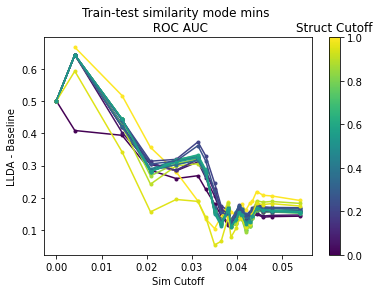

In [16]:
mode = 'mins'
df_plot = df_out[df_out['mode'] == mode]
colormap = cm.viridis
colorparams = df_struct_cutoffs['percentile'].values
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))
for struct_cutoff in set(df_plot['struct_cutoff']):
    percentile = df_struct_cutoffs.iloc[np.abs(df_struct_cutoffs['value'] - struct_cutoff).argmin()]['percentile']
    df = df_plot[df_plot['struct_cutoff'] == struct_cutoff].dropna()
    color = colormap(normalize(percentile))
    plt.plot(df['sim_cutoff'], df['llda-baseline'], marker='.', linestyle='-' ,label = f'{round(struct_cutoff, 2)}', color = color)
plt.xlabel("Sim Cutoff")
plt.ylabel('LLDA - Baseline')
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(colorparams)
cbar = plt.colorbar(s_map)
cbar.ax.set_title('Struct Cutoff')
plt.title(f"Train-test similarity mode {mode} \n ROC AUC")